## clustering

In [5]:
import numpy as np
import os

n = 0
layer = 6
npz = np.load(f'/home/shan/Desktop/multimodal/sae_llava/src/output_llava_top{n}/{layer}_{n}_vlm_features.npz')
npz

NpzFile '/home/shan/Desktop/multimodal/sae_llava/src/output_llava_top0/6_0_vlm_features.npz' with keys: features, sample_ids, hidden_states, label

In [15]:
features = npz['features'].reshape(-1, 1)

# avg, min, max, med, std in features matrix total
avg = np.mean(features, axis=0)
min_ = np.min(features, axis=0)
max_ = np.max(features, axis=0)
med = np.median(features, axis=0)
std = np.std(features, axis=0)

print(f'avg: {avg}')
print(f'min: {min_}')
print(f'max: {max_}')
print(f'med: {med}')
print(f'std: {std}')

# make a function apply to original feature matrix casting all features to 0 or 1 if they are below or above the median
def binarize(features, med):
    return np.where(features < med, 0, 1)

features_bin = binarize(npz['features'], med)

/home/shan/mambaforge/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


avg: [295.2]
min: [0.]
max: [61760.]
med: [7.613]
std: [inf]


In [16]:
features_bin

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

Silhouette Score (Features): 0.33
Silhouette Score (Hidden States): 0.34


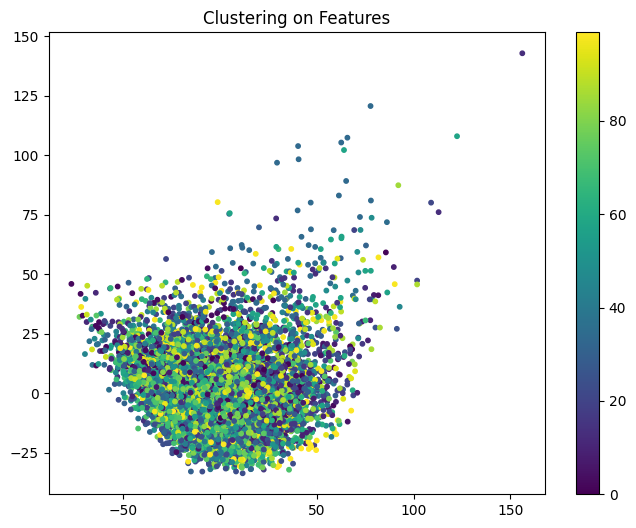

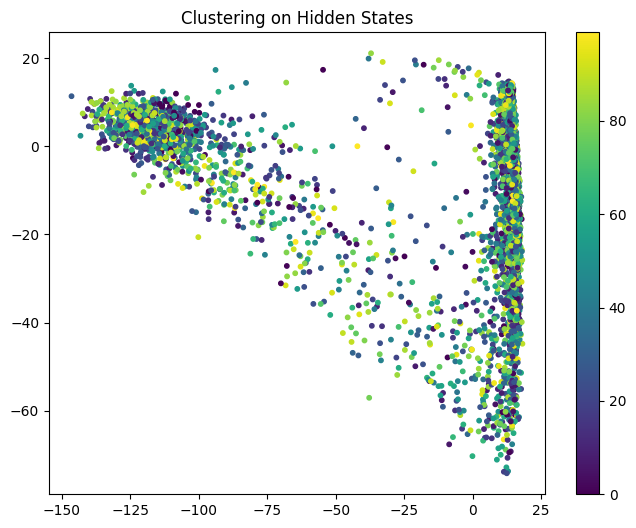

In [18]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt

# Load the data
labels = npz['label']
features = features_bin
hidden_states = npz['hidden_states']

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
hidden_states_scaled = scaler.fit_transform(hidden_states)

# Dimensionality reduction using PCA
pca_features = PCA(n_components=2).fit_transform(features_scaled)
pca_hidden_states = PCA(n_components=2).fit_transform(hidden_states_scaled)

# Clustering using K-Means
n_clusters = len(np.unique(labels))  # Number of unique classes
kmeans_features = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_features)
kmeans_hidden_states = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_hidden_states)

silhouette_features = silhouette_score(pca_features, kmeans_features.labels_)
silhouette_hidden_states = silhouette_score(pca_hidden_states, kmeans_hidden_states.labels_)

print(f"Silhouette Score (Features): {silhouette_features:.2f}")
print(f"Silhouette Score (Hidden States): {silhouette_hidden_states:.2f}")

# Visualize the clustering
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()

plot_clusters(pca_features, labels, "Clustering on Features")
plot_clusters(pca_hidden_states, labels, "Clustering on Hidden States")


## old stuffs

In [2]:
import numpy as np

path = "/home/shan/Desktop/multimodal/sae_llava/src/output_llm_both1/google_gemma-2-2b/Anthropic_election_questions/test/layer_12/16k/"
# read npz file
npzfile = np.load(f"{path}sample_1.npz")
npzfile

NpzFile '/home/shan/Desktop/multimodal/sae_llava/src/output_llm_both1/google_gemma-2-2b/Anthropic_election_questions/test/layer_12/16k/sample_1.npz' with keys: sae_acts, hidden_state

In [8]:
npzfile['sae_acts'].shape, npzfile['hidden_state'].shape

((1, 22, 16384), (22, 2304))

In [4]:
import numpy as np

a = np.load("/home/shan/Desktop/multimodal/sae_llava/src/output_llava_top0/17_0_vlm_features.npz")
a['hidden_states'].shape, a['features'].shape, a['label'].shape

KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import logging
import pandas as pd

# Set up logging
logging.basicConfig(level=logging.INFO)

# Parameters
top_x = 0
layers = [6, 10, 17]
binary_options = [True, False]
batch_size = 64  # Adjust based on available memory
num_epochs = 10  # Adjust as needed
learning_rate = 0.001
results = []

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a simple linear probe model
class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

# Iterate over layers and binary options
for layer in layers:
    for binary in binary_options:
        print(f"=== Processing layer {layer}, binary={binary} ===")

        # Load your data from the .npz file
        data_path = f"/home/shan/Desktop/netlab/output_llava_top0/{layer}_{top_x}_vlm_features.npz"
        data = np.load(data_path)

        # Extract features and labels
        features = torch.tensor(data['features'].astype('float32')).to(device)
        labels = torch.tensor(data['label'].astype('int64')).to(device)

        # Apply binary encoding if specified
        if binary:
            print("Applying one-hot encoding to features")
            features = torch.where(features > 0, 1.0, 0.0)

        # Create a dataset and DataLoader
        dataset = TensorDataset(features, labels)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Initialize the linear probe model
        input_dim = features.shape[1]  # Number of input features
        num_classes = len(torch.unique(labels))  # Number of classes
        model = LinearProbe(input_dim, num_classes).to(device)

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            for batch_features, batch_labels in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                # Forward pass
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_features, batch_labels in test_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = model(batch_features)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Accuracy of the model on the test set: {accuracy:.2f}%")

        # Collect results
        results.append({
            'layer': layer,
            'binary': binary,
            'accuracy': accuracy
        })

# Display results
results_df = pd.DataFrame(results)
print("\n=== Summary of Results ===")
print(results_df)


=== Processing layer 6 ===


  0%|          | 0/3 [1:16:42<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (36864x2048 and 576x100)

In [ ]:
n x 576 x 2048 

In [1]:
from classifiers_cuml import *
import cupy as cp
import numpy as np
from pathlib import Path
import logging
from cuml.model_selection import train_test_split

# Set up logging
logging.basicConfig(level=logging.INFO)

top_x = 0
layers = [6, 10, 17]
binary_options = [True, False]
hidden = True
sae = False
# Initialize a list to store results
results = []

# Iterate over layers and binary options
for layer in layers:
    for binary in binary_options:
        print(f"=== Processing layer {layer}, binary={binary} ===")

        # Load your data from the .npz file
        data_path = f"/home/shan/Desktop/netlab/output_llava_top0/{layer}_{top_x}_vlm_features.npz"
        data = np.load(data_path)
        
        if sae:
        # Extract features and labels directly from the npz file
            features = cp.asarray(data['features'].astype('float32'))
                    # Process features based on binary flag
            if binary:
                print("Applying one-hot encoding to features")
                features = cp.where(features > 0, 1.0, 0.0).astype('float32')
            else:
                print("Using raw features")
            
            labels = cp.asarray(data['label'].astype('int32'))
                    # Split data into training and test sets
            X_train, X_test, y_train, y_test = train_test_split(
                features, labels, test_size=0.2, random_state=42
            )

        # Define training configuration
        config = TrainingConfig()

        # Instantiate the trainer
        trainer = ModelTrainer(config)

        # Train models with the enhanced pipeline
        print("===== Training models =====")

        if hidden:
            # Extract hidden states
            hidden_states = cp.asarray(data['hidden_states'].astype('float16'))
            labels = cp.asarray(data['label'].astype('int16'))
            # Split data into training and test sets
            X_train_hidden, X_test_hidden, y_train, y_test = train_test_split(
                hidden_states, labels, test_size=0.5, random_state=42
            )

            # Train linear probe on hidden states
            print("Training linear probe on hidden states")
            hidden_linear_results = trainer.train_linear_probe_hidden(
                X_train_hidden, y_train, X_test_hidden, y_test
            )

            # Collect results
            results.append({
                'layer': layer,
                'binary': binary,
                'hidden_linear_accuracy': hidden_linear_results,
            })
        else:
            # Train linear probe on SAE features
            print("Training linear probe on SAE features")
            sae_linear_results = trainer.train_linear_probe(
                X_train, y_train, X_test, y_test, hidden=False
            )

            # Collect results
            results.append({
                'layer': layer,
                'binary': binary,
                'sae_linear_accuracy': sae_linear_results
            })

# Display results
results_df = pd.DataFrame(results)
print("\n=== Summary of Results ===")
print(results_df)

/home/shan/mambaforge/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Processing layer 6, binary=True ===
===== Training models =====


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /tmp/pip-build-env-z8x7r21l/normal/lib/python3.12/site-packages/librmm/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory

In [7]:
from classifiers_cuml import *
import cupy as cp
import cudf
import numpy as np
import pandas as pd
from pathlib import Path
import logging
from cuml.model_selection import train_test_split
import scipy.sparse as sp

# Set up logging
logging.basicConfig(level=logging.INFO)

top_x = 0
layers = [6, 10, 17]
binary_options = [True, False]
hidden = True
sae = False
# Initialize a list to store results
results = []

# Iterate over layers and binary options
for layer in layers:
    for binary in binary_options:
        print(f"=== Processing layer {layer}, binary={binary} ===")

        # Load your data from the .npz file
        data_path = f"/home/shan/Desktop/netlab/output_llava_top0/{layer}_{top_x}_vlm_features.npz"
        data = np.load(data_path)
        
        # Create a pandas DataFrame
        df = pd.DataFrame({
            'hidden_states': list(data['hidden_states'].astype('float32')),  # Each element is an array
            'features': list(sp.csr_matrix(data['features'].astype('int8'))),  # Each element is a sparse matrix
            'label': data['label'].astype('int8')
        })

        # Process features based on binary flag
        if binary:
            print("Applying one-hot encoding to features")
            df['features'] = df['features'].apply(lambda x: sp.csr_matrix(np.where(x.toarray() > 0, 1, 0)))
        else:
            print("Using raw features")

        # Convert pandas DataFrame to cuDF DataFrame
        features_cudf = cudf.DataFrame.from_pandas(pd.DataFrame.sparse.from_spmatrix(df['features'].tolist()))
        labels_cudf = cudf.Series(df['label'].values)

        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            features_cudf, labels_cudf, test_size=0.2, random_state=42
        )

        # Define training configuration
        config = TrainingConfig()

        # Instantiate the trainer
        trainer = ModelTrainer(config)

        # Train models with the enhanced pipeline
        print("===== Training models =====")

        if hidden:
            # Extract hidden states
            hidden_states = cp.asarray(data['hidden_states'].astype('float16'))
            labels = cp.asarray(data['label'].astype('int16'))
            # Split data into training and test sets
            X_train_hidden, X_test_hidden, y_train, y_test = train_test_split(
                hidden_states, labels, test_size=0.5, random_state=42
            )

            # Train linear probe on hidden states
            print("Training linear probe on hidden states")
            hidden_linear_results = trainer.train_linear_probe_hidden(
                X_train_hidden, y_train, X_test_hidden, y_test
            )

            # Collect results
            results.append({
                'layer': layer,
                'binary': binary,
                'hidden_linear_accuracy': hidden_linear_results,
                'sae_linear_accuracy': sae_linear_results
            })
        else:
            # Train linear probe on SAE features
            print("Training linear probe on SAE features")
            sae_linear_results = trainer.train_linear_probe(
                X_train, y_train, X_test, y_test, hidden=False
            )

            # Collect results
            results.append({
                'layer': layer,
                'binary': binary,
                'sae_linear_accuracy': sae_linear_results
            })

# Display results
results_df = pd.DataFrame(results)
print("\n=== Summary of Results ===")
print(results_df)

=== Processing layer 6, binary=True ===


: 

In [6]:
from classifiers_cuml import *
import cupy as cp
import cudf
import numpy as np
import pandas as pd
from pathlib import Path
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

top_x = 0
layers = [6, 10, 17]
binary_options = [True, False]
hidden = False
# Initialize a list to store results
results = []

# Iterate over layers and binary options
for layer in layers:
    for binary in binary_options:
        print(f"=== Processing layer {layer}, binary={binary} ===")

        # Load your data from the .npz file
        data_path = f"/home/shan/Desktop/multimodal/sae_llava/src/output_llava_top{top_x}/{layer}_{top_x}_vlm_features.npz"
        data = np.load(data_path)
        
        # Create a pandas DataFrame
        df = pd.DataFrame({
            'hidden_states': list(data['hidden_states'].astype('float32')),  # Each element is an array
            'features': list(data['features'].astype('int8')),               # Each element is an array
            'label': data['label'].astype('int8')
        })

        # Process features based on binary flag
        if binary:
            print("Applying one-hot encoding to features")
            df['features'] = df['features'].apply(lambda x: np.where(x > 0, 1, 0))
        else:
            print("Using raw features")

        # Convert pandas DataFrame to cuDF DataFrame
        df_cudf = cudf.from_pandas(df)

        # Define training configuration
        config = TrainingConfig()

        # Define output directory, model name, and layer
        output_dir = Path("./model_output")
        model_name = "my_model"
        current_layer = f"layer_{layer}"

        # Instantiate the trainer
        trainer = ModelTrainer(config)

        # Train models with the enhanced pipeline
        print("===== Training models =====")

        # SAE features
        print("Training linear probe on SAE features")
        sae_linear_results = trainer.train_linear_probe(df_cudf, hidden=False)

        if hidden:
            # Hidden states
            print("Training linear probe on hidden states")
            hidden_linear_results = trainer.train_linear_probe(df_cudf, hidden=True)
            # Collect results
            results.append({
                'layer': layer,
                'binary': binary,
                'hidden_linear_accuracy': hidden_linear_results,
                'sae_linear_accuracy': sae_linear_results
            })
        else:
            # Collect results
            results.append({
                'layer': layer,
                'binary': binary,
                'sae_linear_accuracy': sae_linear_results
            })

# Display results nicely
results_df = pd.DataFrame(results)
print("\n=== Summary of Results ===")
print(results_df)

/home/shan/mambaforge/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Processing layer 6, binary=True ===
Applying one-hot encoding to features


ValueError: setting an array element with a sequence.

In [19]:
import numpy as np

a = np.load("/home/shan/Desktop/multimodal/sae_llava/results/llm_features5_last_new.npz")
a['hidden_states'].shape, a['features'].shape

((743, 2304), (743, 16384))

In [20]:
b = np.load("/home/shan/Desktop/multimodal/sae_llava/src/output_llm_both/google_gemma-2-2b/Anthropic_election_questions/test/layer_5/16k/llm_features.npz")
b['hidden_states'].shape, b['features'].shape

((743, 2304), (743, 16384))

In [21]:
# check b and a are the same

a['hidden_states'] == b['hidden_states']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

In [3]:
import numpy as np

# path = "output_llm_both/google_gemma-2-2b/Anthropic_election_questions/test/layer_5/16k/llm_features.npz"
# path = "output_llm_both/google_gemma-2-2b/textdetox_multilingual_toxicity_dataset/en/layer_5/16k/llm_features.npz"
path = "/home/jg1223/sae_llava/src/output_llm_both/google_gemma-2-2b/Anthropic_election_questions/test/layer_5/16k/sample_0.npz"
# read npz file
data = np.load(f"{path}")
npzfile = data
data

NpzFile '/home/jg1223/sae_llava/src/output_llm_both/google_gemma-2-2b/Anthropic_election_questions/test/layer_5/16k/sample_0.npz' with keys: sae_acts, hidden_state

In [1]:
import numpy as np
## for a single instance from llm output
path = "/home/shan/Desktop/multimodal/sae_llava/src/output_llm_both/google_gemma-2-2b/Anthropic_election_questions/test/layer_5/16k/sample_0.npz"
# path = "output_llm_both/google_gemma-2-2b/textdetox_multilingual_toxicity_dataset/en/layer_5/16k/llm_features.npz"
# read npz file
data = np.load(f"{path}")
data

(1, 21, 16384)

In [2]:
# 1, hidden_dim
data["hidden_state"].shape

(21, 2304)

In [3]:
# 1, 1, sae_dim
data["sae_acts"].shape

(1, 1, 16384)

In [4]:
final_data = np.load("/home/shan/Desktop/multimodal/sae_llava/src/output_llm_both/google_gemma-2-2b/Anthropic_election_questions/test/layer_5/16k/llm_features.npz")
final_data

NpzFile '/home/shan/Desktop/multimodal/sae_llava/src/output_llm_both/google_gemma-2-2b/Anthropic_election_questions/test/layer_5/16k/llm_features.npz' with keys: features, sample_ids, hidden_states, label

In [5]:
final_data['label'].shape, final_data['hidden_states'].shape, final_data['features'].shape

((743,), (743, 2304), (743, 16384))

In [11]:
import numpy as np

array = np.zeros(1000000, dtype=np.float16)
print(f"Array size in bytes: {array.nbytes}")
print(f"Array size in megabytes: {array.nbytes / (1024**2):.3f} MB")


Array size in bytes: 2000000
Array size in megabytes: 1.907 MB


In [7]:
#check how large data["sae_acts"] is for vram
data["sae_acts"].nbytes / 1e9


0.037748736

In [4]:
data["hidden_state"].shape

(576, 2048)

In [5]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import requests
import torch

model_id = "google/paligemma-3b-mix-224"
device = "cuda:0"
dtype = torch.bfloat16

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
).eval()
processor = AutoProcessor.from_pretrained(model_id)

# Instruct the model to create a caption in Spanish
prompt = "caption es"
model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(
    model.device
)
input_len = model_inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**model_inputs, max_new_tokens=100, do_sample=False)
    generation = generation[0][input_len:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

/home/jg1223/mambaforge/envs/saefari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Un auto azul estacionado frente a un edificio.


In [6]:
# count the number 257152 in tensor
# tensor = torch.tensor([257152, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# print((tensor == 257152).sum().item())

(model_inputs["input_ids"] == 257152).sum().item()

256

In [7]:
import torch
from datasets import load_dataset

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# Global configurations
checkpoint = "Intel/llava-gemma-2b"

KeyboardInterrupt: 

In [9]:
from collections import Counter
import pandas as pd

df_name = "results/imagenet-1k-256x256_gemma-2b-it_layer12.csv"
# df_name = 'results/cifar100-enriched_gemma-2b_layer12.csv'
dataset = df_name.split("/")[1].split("_gemma")[0]
layer = df_name.split("layer")[1].split(".csv")[0]
release = df_name.split("/")[1].split("_")[1].split("_layer")[0]
if "imagenet" in dataset:
    num_classes = 1000
    ds = "benjamin-paine/imagenet-1k-256x256"
else:
    num_classes = 100
    ds = "renumics/cifar100-enriched"

df = pd.read_csv(df_name)

FileNotFoundError: [Errno 2] No such file or directory: 'results/imagenet-1k-256x256_gemma-2b-it_layer12.csv'

In [ ]:
if ds == "benjamin-paine/imagenet-1k-256x256":
    dataset = load_dataset(ds, split="validation")
else:
    dataset = load_dataset(ds, split="test")
dataset

In [ ]:
checkpoint = "Intel/llava-gemma-2b"
model, processor, sae = load_models_and_processor(checkpoint, layer, release, device)

In [ ]:
image = dataset["image"][0]
image

In [ ]:
prompt = processor.tokenizer.apply_chat_template(
    [{"role": "user", "content": "<image>"}], tokenize=False, add_generation_prompt=True
)
inputs = processor(text=prompt, images=image, return_tensors="pt", padding=True).to(
    device
)

In [ ]:
inputs["input_ids"]

In [ ]:
# i used these visual tokens to activate gemma-2b or gemma-2b-it's sae. and got meaning representations.
# what i want to try now: use these hidden states to generate text based on gemma-2b or gemma-2b-it's sae.

In [ ]:
# TODO: Add the code to generate the text for the image based on gemma_it_layer12

In [23]:
import numpy as np
import pandas as pd
import gc
# Original function
def optimized_top_n_to_one_hot(array, top_n, progress_dict=None, binary=False, int8=False):
    """Memory-efficient top-n to one-hot conversion with progress tracking."""
    if array is None:
        return None
    token_length, dim_size = array.shape
    # Taking top_n activated functions
    top_n_indices = np.argpartition(-array, top_n, axis=1)[:, :top_n]
    sparse_array = np.zeros((token_length, dim_size), dtype=np.uint8)
    # Making [0.1, 0.5, 0.3] to [0, 1, 0] if top_n_indices = [1]
    row_indices = np.arange(token_length)[:, np.newaxis]
    sparse_array[row_indices, top_n_indices] = 1
    result = np.sum(sparse_array, axis=0)
    del sparse_array, row_indices, top_n_indices
    if progress_dict is not None:
        progress_dict["processeditems"] += 1
    if binary:
        # For multiple tokens: [0, 5, 0, 3, 0] -> [0, 1, 0, 1, 0]
        return result.astype(bool)
    if int8:
        # Change all numbers over 255 to 255
        result = np.clip(result, 0, 255)
        return result.astype(np.int8)
    else:
        # uint16 0~65535
        return result.astype(np.uint16)
def batch_optimized_top_n_to_one_hot(array, top_n, progress_dict=None, binary=False, int8=False):
    """
    Memory-efficient and fast top-n to one-hot conversion using sparse matrices.
    """
    if array is None:
        return None

    batch_size, token_length, dim_size = array.shape

    # Step 1: Find indices of top_n activations per token for each sample in the batch
    top_n_indices = np.argpartition(-array, top_n, axis=2)[:, :, :top_n]

    # Step 2: Flatten the indices for efficient processing
    flattened_indices = top_n_indices.reshape(-1)
    flattened_batch_indices = np.repeat(np.arange(batch_size), token_length * top_n)

    # Step 3: Use sparse matrix to count occurrences efficiently
    from scipy.sparse import coo_matrix

    data = np.ones_like(flattened_indices, dtype=np.uint16)
    row_indices = flattened_batch_indices
    col_indices = flattened_indices

    # Create a sparse matrix where each occurrence is a 1
    sparse_counts = coo_matrix(
        (data, (row_indices, col_indices)),
        shape=(batch_size, dim_size),
        dtype=np.uint16
    ).toarray()

    # Clean up variables to free memory
    del top_n_indices, flattened_indices, flattened_batch_indices, data, row_indices, col_indices
    gc.collect()

    # Update progress
    if progress_dict is not None:
        progress_dict["processed_items"] += batch_size

    # Post-process the result based on flags
    if binary:
        sparse_counts = sparse_counts.astype(bool)
    if int8:
        sparse_counts = np.clip(sparse_counts, 0, 255).astype(np.int8)
    else:
        sparse_counts = sparse_counts.astype(np.uint16)

    return sparse_counts


In [24]:
path1 = '/home/shan/Desktop/multimodal/sae_llava/src/output_llm_both/google_gemma-2-2b/Anthropic_election_questions/test/layer_12/16k/'
path2 = '/home/shan/Desktop/multimodal/sae_llava/src/output_llm_both1/google_gemma-2-2b/Anthropic_election_questions/test/layer_12/16k/'
def load_npz_files(path):
    result = []
    for i in range(0,10):
        data = np.load(f"{path}sample_{i}.npz")
        result.append(data['sae_acts'][0])        
    print(data['hidden_state'].shape, data['sae_acts'].shape)
    return result

data1 = load_npz_files(path1)
data2 = load_npz_files(path2)

(1, 2304) (1, 1, 16384)
(22, 2304) (1, 22, 16384)


In [25]:
import numpy as np
import pandas as pd

def cast_sae_acts(sae_acts_list):
    """
    Attempts to cast the 'sae_acts' column of the DataFrame to a NumPy array.
    
    Args:
        sae_acts_list (list): A list of 'sae_acts' values from the DataFrame.
        
    Returns:
        bool: True if casting is successful, False if a ValueError due to inhomogeneous shapes occurs.
    """
    try:
        sae_acts_array = np.array(sae_acts_list)
        
        return True
    except ValueError as e:
        error_message = str(e)
        target_error = (
            "The requested array has an inhomogeneous shape"
        )
        if target_error in error_message:
            return False
        else:
            # Re-raise the exception if it's a different ValueError
            raise

cast_sae_acts(data1), cast_sae_acts(data2) 

(True, True)

In [26]:
batch_df = pd.DataFrame({"sae_acts": data2})
batch_df2 = pd.DataFrame({"sae_acts": data2})

In [27]:
np.stack(data2).shape

(10, 22, 16384)

In [28]:
batch_df2

sae_acts
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
7  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
8  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [29]:
# Test cases
def test_functions():
    # Parameters
    batch_size = 3
    token_length = 4
    dim_size = 6
    top_n = 5
    # progress_dict_original = {"processed_items": 0}
    # progress_dict_batch = {"processed_items": 0}

    # Generate random test data for batch_df["sae_acts"]
    # np.random.seed(0)  # For reproducibility
    # data = []
    # for _ in range(batch_size):
    #     # Generate a random array of shape (token_length, dim_size)
    #     array = np.random.rand(token_length, dim_size)
    #     data.append(array)

    # # Create a DataFrame
    # batch_df = pd.DataFrame({"sae_acts": data})

    # Apply the original function using list comprehension
    batch_df["features_original"] = batch_df["sae_acts"].apply(
        lambda x: optimized_top_n_to_one_hot(x, top_n)
    )

    # Prepare the array for batch processing
    array_batch = np.stack(batch_df["sae_acts"].values)  # Shape: (batch_size, token_length, dim_size)

    # Apply the batch function
    features_batch = batch_optimized_top_n_to_one_hot(
        array_batch, top_n
    )

    # Assign the batch features to the DataFrame
    batch_df["features_batch"] = list(features_batch)

    # Compare the outputs
    all_equal = True
    for idx in range(batch_size):
        original = batch_df.loc[idx, "features_original"]
        batch = batch_df.loc[idx, "features_batch"]
        if not np.array_equal(original, batch):
            all_equal = False
            print(f"Mismatch found in sample {idx}")
            print("Original output:")
            print(original)
            print("Batch output:")
            print(batch)
            print()
        else:
            print(f"Sample {idx} outputs are equal.")

    if all_equal:
        print("\nAll outputs are identical!")

    # Optionally, display the DataFrame
    print("\nDataFrame with features:")
    print(batch_df)
    return batch_df

# Run the test
test_functions()


Sample 0 outputs are equal.
Sample 1 outputs are equal.
Sample 2 outputs are equal.

All outputs are identical!

DataFrame with features:
                                            sae_acts  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
6  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
7  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                   features_original  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0,

sae_acts  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
5  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
6  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
7  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
8  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                   features_original  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
7  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
8  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      features_batch  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [30]:
batch_df["features_batch"][0] 
batch_df["features_original"][0]

# check whether they are the same
for i in range(len(batch_df)):
    print(np.array_equal(batch_df["features_batch"][i], batch_df["features_original"][i]))

True
True
True
True
True
True
True
True
True
True


## post processing

In [1]:
import numpy as np
import pandas as pd

# models.py
import torch
from sae_lens import SAE
import logging

device = "cuda" if torch.cuda.is_available() else "cpu"
last_token = False
# def model_name2_checkpoint(model_name):
# TODO write a function to convert model_name to sae_checkpoint
#     if "google-gemma-2b-it" in model_name:
#         return "Intel/llava-gemma-2b"
#     elif model_name == "gemma-2b-it":
#         return "Intel/llava-gemma-2b-it"
#     else:
#         raise ValueError(f"Unknown model name {model_name}")


def llm_type(model_name):
    if "llava" or "peli" in model_name.lower():
        return "vlm"
    elif "gemma" in model_name.lower():
        return "llm"
    else:
        raise ValueError(f"model name {model_name} is not supported")


def load_sae(layer, device, sae_release):
    logging.info(f"Loading SAE model from release {sae_release}, layer {layer}")
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release=f"{sae_release}-res-jb",
        sae_id=f"blocks.{layer}.hook_resid_post",
        device=device,
    )
    return sae, cfg_dict, sparsity


metadata_csv_path = "output_llm_both/google-gemma-2b-it_12_sae_activations_metadata.csv"

model_name = metadata_csv_path.split("/")[-1].split("_")[0]

layer = metadata_csv_path.split("/")[-1].split("_")[1]

checkpoint = "gemma-2b"

model_name, layer, checkpoint

/home/jg1223/mambaforge/envs/saefari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('google-gemma-2b-it', '12', 'gemma-2b')

In [2]:
def binarize_tensor(tensor):
    """
    Convert all non-zero elements in the tensor to 1, keeping 0s unchanged.

    Parameters:
    tensor (torch.Tensor): Input tensor.

    Returns:
    torch.Tensor: Tensor with non-zero elements set to 1. which will be the final features
    """
    return (tensor != 0).to(torch.int32)  # or `torch.float32` if you need floats


def optimized_top_n_to_one_hot(tensor, top_n, binary=False):
    """
    Convert each row of the input tensor to a sparse one-hot representation,
    where only the top_n values in each row are set to 1.

    Parameters:
    tensor (torch.Tensor): Input tensor of shape (token_length, 16384).
    top_n (int): Number of top values to retain per row.
    binary (bool): Whether to convert to binary values

    Returns:
    numpy.ndarray: Transformed array with the same shape but sparsified.
    """
    # Shape info
    token_length, dim_size = tensor.shape

    # Initialize the sparse tensor with zeros
    sparse_tensor = torch.zeros_like(tensor)

    # Get top_n indices for each row in a vectorized way
    top_n_indices = torch.topk(tensor, top_n, dim=1).indices

    # Use `scatter_` to set top_n indices to 1 in the sparse tensor
    sparse_tensor.scatter_(1, top_n_indices, 1)

    if binary:
        sparse_tensor = binarize_tensor(sparse_tensor.sum(dim=0).to(device))
    else:
        sparse_tensor = sparse_tensor.sum(dim=0).to(device)

    return sparse_tensor


# numpy to torch tensor
def hidden2sparse(data, sae):
    if data is not None:
        return sae.encode(torch.tensor(data).to(device).to(torch.float32))
    return None


sae, cfg_dict, sparsity = load_sae(layer, device, checkpoint)

In [3]:
metadata_df = pd.read_csv(metadata_csv_path)


# Define a helper function to process each row based on index
def load_npz_data(index):
    # Access file path and label directly
    sample_id = metadata_df.at[index, "sample_id"]
    label = metadata_df.at[index, "label"]
    npz_file_path = metadata_df.at[index, "npz_file"]

    # Load the .npz file only once to check for keys and fetch data
    npz_data = np.load(npz_file_path)
    sae_acts = npz_data["sae_acts"] if "sae_acts" in npz_data else None
    hidden_state = npz_data["hidden_state"]

    return {
        "sample_id": sample_id,
        "label": label,
        "sae_acts": sae_acts,
        "hidden_state": hidden_state,
    }


# Use map to apply the function over all indices, which is often faster than list comprehensions
data_samples = list(map(load_npz_data, range(len(metadata_df))))

# Convert to DataFrame if desired
loaded_data_df = pd.DataFrame(data_samples)

# Optional: Display first few loaded samples
loaded_data_df.head()

sample_id        label                                           sae_acts  \
0          0      Neutral  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
1          1      Neutral  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
2          2      Neutral  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3          3  Challenging  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
4          4  Challenging  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   

                                        hidden_state  
0  [[0.16276622, -0.0086735785, 0.25471422, -0.15...  
1  [[0.18731156, -0.0348662, 0.24404684, -0.15457...  
2  [[0.1606347, 0.023152478, 0.25660866, -0.14793...  
3  [[0.18019646, -0.060171515, 0.2424412, -0.1309...  
4  [[0.162075, -0.029491395, 0.27113217, -0.15203...

In [4]:
def add_feature_vector(
    loaded_data_df, cfg_dict, sae, device, last_token=False, top_n=5
):
    """
    Add feature vectors to the loaded DataFrame based on SAE activations.

    Args:
        loaded_data_df (pd.DataFrame): DataFrame with hidden_state and optionally sae_acts
        cfg_dict (dict): Configuration dictionary from SAE
        sae (SAE): Loaded SAE model
        device (str): Device to use for computation
        last_token (bool): Whether to use only the last token for processing
        top_n (int): Number of top values to retain per row

    Returns:
        pd.DataFrame: Processed DataFrame with features added
    """
    # Case 1: SAE activations already exist
    if "sae_acts" in loaded_data_df.columns:
        # Validate dimensions
        if loaded_data_df["sae_acts"][0].shape[-1] != cfg_dict["d_sae"]:
            raise ValueError(
                f"SAE activations shape mismatch: {loaded_data_df['sae_acts'][0].shape[-1]} != {cfg_dict['d_sae']}"
            )

        # Handle single-token case
        if loaded_data_df["sae_acts"][0].shape[0] == 1:
            loaded_data_df["sae_acts"] = loaded_data_df["sae_acts"].apply(
                lambda x: x[0]
            )

    # Case 2: Need to compute SAE activations from hidden states
    else:
        logging.info("Computing SAE activations from hidden states")
        if last_token:
            # Process only last tokens
            last_tokens = [state[-1] for state in loaded_data_df["hidden_state"]]
            hidden_tensor = (
                torch.tensor(np.stack(last_tokens)).to(torch.float32).to(device)
            )
            loaded_data_df["sae_acts"] = [hidden2sparse(hidden_tensor, sae)]
        else:
            # Process all tokens
            loaded_data_df["sae_acts"] = loaded_data_df["hidden_state"].apply(
                lambda x: hidden2sparse(x, sae)
            )

    # Generate features using top-n approach and convert to numpy arrays
    logging.info(f"Generating features with top_{top_n} approach")
    loaded_data_df["features"] = loaded_data_df["sae_acts"].apply(
        lambda x: optimized_top_n_to_one_hot(torch.tensor(x), top_n).cpu().numpy()
    )

    # Ensure sae_acts are also in numpy format if they're torch tensors
    if torch.is_tensor(loaded_data_df["sae_acts"].iloc[0]):
        loaded_data_df["sae_acts"] = loaded_data_df["sae_acts"].apply(
            lambda x: x.cpu().numpy() if torch.is_tensor(x) else x
        )

    return loaded_data_df


loaded_data_df = add_feature_vector(loaded_data_df, cfg_dict, sae, device, last_token)

loaded_data_df.head()

sample_id        label                                           sae_acts  \
0          0      Neutral  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1          1      Neutral  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2          2      Neutral  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3          3  Challenging  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4          4  Challenging  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                        hidden_state  \
0  [[0.16276622, -0.0086735785, 0.25471422, -0.15...   
1  [[0.18731156, -0.0348662, 0.24404684, -0.15457...   
2  [[0.1606347, 0.023152478, 0.25660866, -0.14793...   
3  [[0.18019646, -0.060171515, 0.2424412, -0.1309...   
4  [[0.162075, -0.029491395, 0.27113217, -0.15203...   

                                            features  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

### Classifiers


Linear Probe Results:
              precision    recall  f1-score   support

 Challenging       0.43      0.50      0.46         6
     Neutral       0.45      0.50      0.48        10
     Trivial       0.50      0.25      0.33         4

    accuracy                           0.45        20
   macro avg       0.46      0.42      0.42        20
weighted avg       0.46      0.45      0.44        20


Decision Tree Results:
              precision    recall  f1-score   support

 Challenging       0.25      0.33      0.29         6
     Neutral       0.56      0.50      0.53        10
     Trivial       0.00      0.00      0.00         4

    accuracy                           0.35        20
   macro avg       0.27      0.28      0.27        20
weighted avg       0.35      0.35      0.35        20



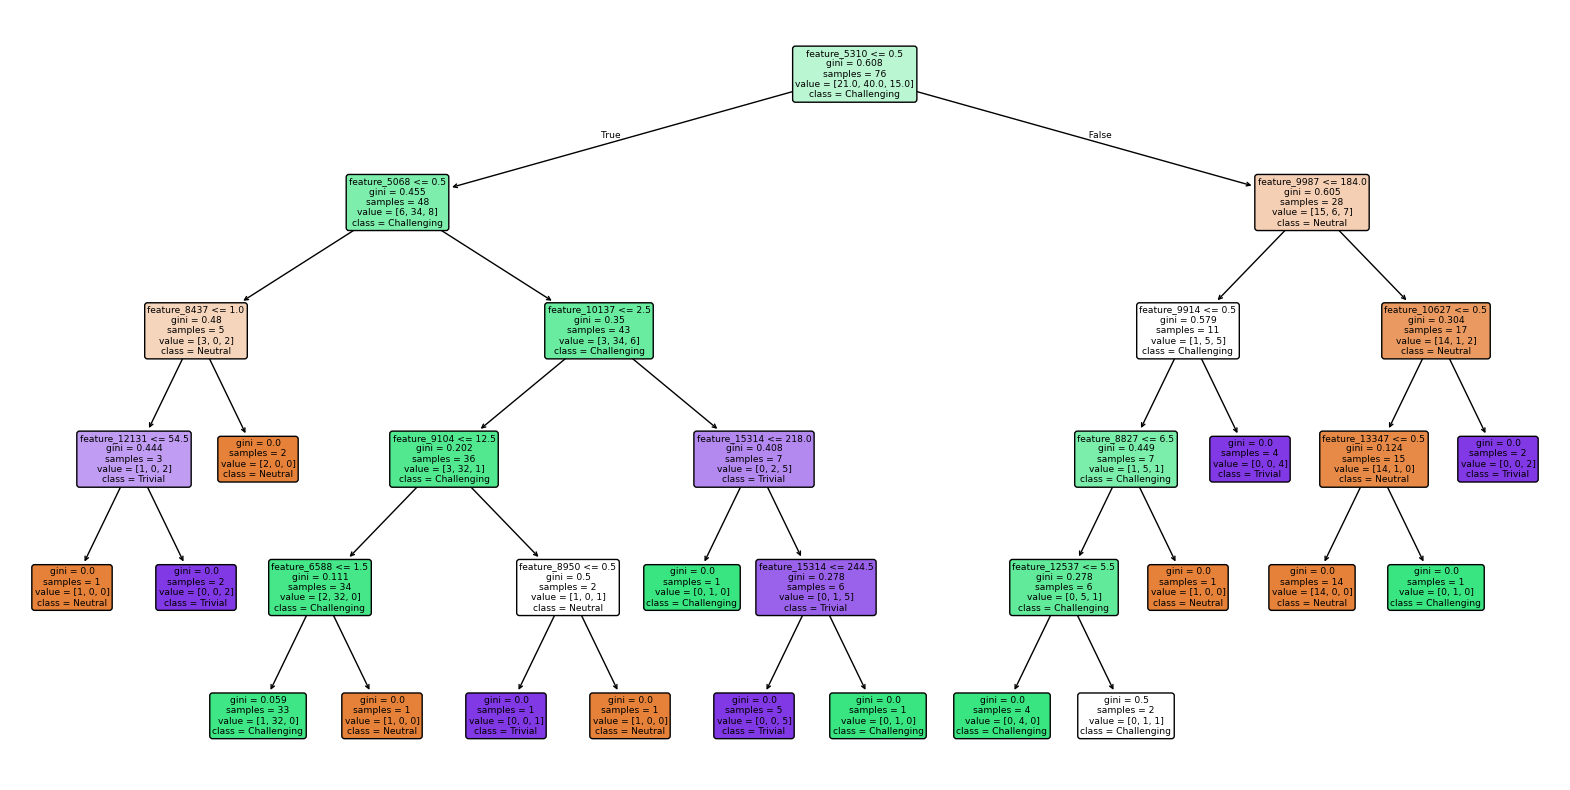

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def prepare_hidden_states_for_linear_probe(hidden_states, max_length=None):
    """
    Prepare hidden states for linear probe by handling padding.
    Either truncate or pad sequences to max_length.

    Args:
        hidden_states (list): List of hidden state arrays
        max_length (int): Maximum sequence length. If None, use max length in data

    Returns:
        np.array: Processed hidden states array of shape (n_samples, max_len, hidden_dim)
    """
    if max_length is None:
        max_length = max(state.shape[0] for state in hidden_states)

    hidden_dim = hidden_states[0].shape[1]
    n_samples = len(hidden_states)

    # Initialize padded array
    padded_states = np.zeros((n_samples, max_length, hidden_dim))

    # Fill in the actual values
    for i, state in enumerate(hidden_states):
        seq_len = min(state.shape[0], max_length)
        padded_states[i, :seq_len] = state[:seq_len]

    return padded_states


def train_linear_probe(df, test_size=0.2, random_state=42):
    """
    Train a linear probe classifier using hidden states.

    Args:
        df (pd.DataFrame): DataFrame with hidden_state and label columns
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility

    Returns:
        dict: Dictionary containing model, predictions, and metrics
    """
    # Prepare hidden states
    hidden_states = list(df["hidden_state"])
    padded_states = prepare_hidden_states_for_linear_probe(hidden_states)

    # Reshape to 2D for classifier (samples, features)
    n_samples, seq_len, hidden_dim = padded_states.shape
    X = padded_states.reshape(n_samples, -1)

    # Prepare labels
    y = df["label"]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Train classifier
    clf = LogisticRegression(max_iter=1000, random_state=random_state)
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Compile results
    results = {
        "model": clf,
        "predictions": y_pred,
        "y_test": y_test,
        "X_test": X_test,
        "X_train": X_train,
        "y_train": y_train,
        "report": classification_report(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
    }

    return results


def train_decision_tree(df, max_depth=5, test_size=0.2, random_state=42):
    """
    Train a decision tree classifier using feature vectors.

    Args:
        df (pd.DataFrame): DataFrame with features and label columns
        max_depth (int): Maximum depth of the decision tree
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility

    Returns:
        dict: Dictionary containing model, predictions, and metrics
    """
    # Prepare features
    X = np.stack(df["features"].values)
    y = df["label"]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Train classifier
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Compile results
    results = {
        "model": clf,
        "predictions": y_pred,
        "y_test": y_test,
        "X_test": X_test,
        "X_train": X_train,
        "y_train": y_train,
        "report": classification_report(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
    }

    return results


def plot_tree_visualization(tree_results, feature_names=None, class_names=None):
    """
    Plot the decision tree visualization.

    Args:
        tree_results (dict): Results dictionary from train_decision_tree
        feature_names (list): List of feature names
        class_names (list): List of class names
    """
    plt.figure(figsize=(20, 10))
    plot_tree(
        tree_results["model"],
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
    )
    plt.show()


# Assuming processed_df is your processed DataFrame
# Train linear probe
linear_results = train_linear_probe(loaded_data_df)
print("\nLinear Probe Results:")
print(linear_results["report"])

# Train decision tree
tree_results = train_decision_tree(loaded_data_df)
print("\nDecision Tree Results:")
print(tree_results["report"])

# Plot decision tree
# Get unique labels for class names
class_names = loaded_data_df["label"].unique().tolist()
# Create feature names (optional)
feature_names = [
    f"feature_{i}" for i in range(loaded_data_df["features"].iloc[0].shape[0])
]

plot_tree_visualization(tree_results, feature_names, class_names)

In [6]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy.special import softmax
from sklearn.metrics import roc_curve, auc
import pandas as pd
from typing import Dict, Any, List
import umap
from sklearn.preprocessing import StandardScaler


class ClassifierVisualizer:
    def __init__(
        self,
        linear_results: Dict[str, Any],
        tree_results: Dict[str, Any],
        processed_df: pd.DataFrame,
        feature_names=None,
        max_seq_length=None,
    ):
        """Initialize visualizer with classifier results and data."""
        self.linear_results = linear_results
        self.tree_results = tree_results
        self.processed_df = processed_df

        # Get correct feature dimensionality
        if hasattr(self.linear_results["model"], "coef_"):
            n_features = self.linear_results["model"].coef_.shape[1]
        else:
            n_features = self.tree_results["model"].n_features_in_

        self.feature_names = (
            feature_names
            if feature_names is not None
            else [f"feature_{i}" for i in range(n_features)]
        )

        # Pre-compute UMAP projections for hidden states with proper padding
        padded_states = self._prepare_hidden_states(
            processed_df["hidden_state"], max_seq_length
        )
        self.hidden_states_2d = self._compute_umap(padded_states)

    def _prepare_hidden_states(self, hidden_states, max_length=None):
        """Prepare hidden states by padding/truncating to same length."""
        if max_length is None:
            max_length = max(state.shape[0] for state in hidden_states)

        hidden_dim = hidden_states[0].shape[1]
        n_samples = len(hidden_states)

        padded_states = np.zeros((n_samples, max_length * hidden_dim))

        for i, state in enumerate(hidden_states):
            seq_len = min(state.shape[0], max_length)
            flat_state = state[:seq_len].reshape(-1)
            padded_states[i, : len(flat_state)] = flat_state

        return padded_states

    def _compute_umap(self, data: np.ndarray) -> np.ndarray:
        """Compute 2D UMAP projection."""
        reducer = umap.UMAP(random_state=42)
        return reducer.fit_transform(StandardScaler().fit_transform(data))

    def plot_feature_importance(self) -> go.Figure:
        """Create interactive feature importance visualization for both classifiers."""
        importance_data = []

        # Handle linear probe coefficients
        if hasattr(self.linear_results["model"], "coef_"):
            # For binary classification
            if len(self.linear_results["model"].coef_.shape) == 2:
                linear_coef = np.abs(self.linear_results["model"].coef_[0])
            # For single output
            else:
                linear_coef = np.abs(self.linear_results["model"].coef_)

            for feat, imp in zip(self.feature_names, linear_coef):
                importance_data.append(
                    {
                        "Feature": feat,
                        "Importance": float(imp),  # Convert to native Python float
                        "Classifier": "Linear Probe",
                    }
                )

        # Handle decision tree feature importances
        if hasattr(self.tree_results["model"], "feature_importances_"):
            for feat, imp in zip(
                self.feature_names, self.tree_results["model"].feature_importances_
            ):
                importance_data.append(
                    {
                        "Feature": feat,
                        "Importance": float(imp),  # Convert to native Python float
                        "Classifier": "Decision Tree",
                    }
                )

        # Create DataFrame from list of dicts
        importance_df = pd.DataFrame(importance_data)

        # Sort by importance
        importance_df = importance_df.sort_values("Importance", ascending=False)

        # Take top 20 features for visibility
        importance_df = importance_df.groupby("Classifier").head(20)

        # Create interactive plot
        fig = px.bar(
            importance_df,
            x="Feature",
            y="Importance",
            color="Classifier",
            barmode="group",
            title="Top 20 Most Important Features per Classifier",
            template="plotly_white",
        )

        fig.update_layout(height=600, showlegend=True, xaxis_tickangle=-45)

        return fig

    def plot_decision_confidence(self) -> go.Figure:
        """Create interactive visualization of classification confidence."""
        try:
            linear_probs = self.linear_results["model"].predict_proba(
                self.linear_results["X_test"]
            )
            tree_probs = self.tree_results["model"].predict_proba(
                self.tree_results["X_test"]
            )
        except AttributeError:
            # Handle case where model doesn't support predict_proba
            return go.Figure().add_annotation(
                text="Models don't support probability predictions",
                xref="paper",
                yref="paper",
                x=0.5,
                y=0.5,
                showarrow=False,
            )

        fig = make_subplots(
            rows=1,
            cols=2,
            subplot_titles=("Linear Probe Confidence", "Decision Tree Confidence"),
        )

        for i, (probs, name, results) in enumerate(
            [
                (linear_probs, "Linear Probe", self.linear_results),
                (tree_probs, "Decision Tree", self.tree_results),
            ],
            1,
        ):
            max_probs = np.max(probs, axis=1)
            predictions = np.argmax(probs, axis=1)
            correct = predictions == results["model"].classes_.searchsorted(
                results["y_test"]
            )

            fig.add_trace(
                go.Histogram(
                    x=max_probs[correct],
                    name=f"{name} (Correct)",
                    opacity=0.75,
                    marker_color="green",
                ),
                row=1,
                col=i,
            )

            fig.add_trace(
                go.Histogram(
                    x=max_probs[~correct],
                    name=f"{name} (Incorrect)",
                    opacity=0.75,
                    marker_color="red",
                ),
                row=1,
                col=i,
            )

        fig.update_layout(
            height=400,
            title="Classification Confidence Distribution",
            barmode="overlay",
            template="plotly_white",
        )

        return fig

    def plot_embedding_space(self) -> go.Figure:
        """Create interactive visualization of the hidden state embedding space."""
        fig = px.scatter(
            x=self.hidden_states_2d[:, 0],
            y=self.hidden_states_2d[:, 1],
            color=self.processed_df["label"],
            title="Hidden State Embedding Space (UMAP)",
            template="plotly_white",
            labels={"color": "Label"},
        )

        fig.update_layout(height=500, showlegend=True)

        return fig

    def plot_multiclass_roc(self, clf_results, name) -> List[go.Scatter]:
        """
        Create ROC curves for multiclass classification using one-vs-rest approach.

        Args:
            clf_results: Dictionary containing model and test data
            name: Name of the classifier

        Returns:
            List of plotly Scatter traces
        """
        traces = []
        y_test = pd.get_dummies(clf_results["y_test"]).values
        y_score = clf_results["model"].predict_proba(clf_results["X_test"])

        # Get class names
        classes = clf_results["model"].classes_

        # Calculate ROC curve and ROC area for each class
        for i, class_name in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)

            traces.append(
                go.Scatter(
                    x=fpr,
                    y=tpr,
                    name=f"{name} - {class_name} (AUC={roc_auc:.3f})",
                    line=dict(width=2),
                )
            )

        return traces

    def create_interactive_dashboard(self) -> go.Figure:
        """Combine all visualizations into an interactive dashboard."""
        fig = make_subplots(
            rows=2,
            cols=2,
            subplot_titles=(
                "Feature Importance",
                "Classification Confidence",
                "Embedding Space",
                "ROC Curves (One-vs-Rest)",
            ),
            specs=[
                [{"type": "bar"}, {"type": "histogram"}],
                [{"type": "scatter"}, {"type": "scatter"}],
            ],
            vertical_spacing=0.15,
            horizontal_spacing=0.1,
        )

        # Add all plots
        importance_fig = self.plot_feature_importance()
        confidence_fig = self.plot_decision_confidence()
        embedding_fig = self.plot_embedding_space()

        # Add traces from each figure
        for trace in importance_fig.data:
            fig.add_trace(trace, row=1, col=1)
        for trace in confidence_fig.data:
            fig.add_trace(trace, row=1, col=2)
        for trace in embedding_fig.data:
            fig.add_trace(trace, row=2, col=1)

        # Add multiclass ROC curves
        for clf_results, name in [
            (self.linear_results, "Linear Probe"),
            (self.tree_results, "Decision Tree"),
        ]:
            roc_traces = self.plot_multiclass_roc(clf_results, name)
            for trace in roc_traces:
                fig.add_trace(trace, row=2, col=2)

        # Add diagonal line for ROC plot
        fig.add_trace(
            go.Scatter(
                x=[0, 1],
                y=[0, 1],
                line=dict(color="gray", dash="dash"),
                name="Random Classifier",
                showlegend=False,
            ),
            row=2,
            col=2,
        )

        # Update layouts
        fig.update_xaxes(title_text="False Positive Rate", row=2, col=2)
        fig.update_yaxes(title_text="True Positive Rate", row=2, col=2)

        fig.update_layout(
            height=1000,
            title="Interactive Classifier Analysis Dashboard",
            template="plotly_white",
            showlegend=True,
            legend=dict(
                yanchor="bottom", y=-0.2, xanchor="center", x=0.5, orientation="h"
            ),
        )

        return fig


def main():
    visualizer = ClassifierVisualizer(
        linear_results=linear_results,
        tree_results=tree_results,
        processed_df=loaded_data_df,
    )

    dashboard = visualizer.create_interactive_dashboard()
    dashboard.show()

    return visualizer


visualizer = ClassifierVisualizer(
    linear_results=linear_results,
    tree_results=tree_results,
    processed_df=loaded_data_df,
)

# Show full dashboard
visualizer.create_interactive_dashboard().show()

/home/jg1223/mambaforge/envs/saefari/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd


def create_enhanced_dashboard(model_results):
    """
    Create an enhanced visualization dashboard for classifier results.

    Parameters:
    model_results: dict containing:
        - model: trained classifier model
        - X_train: training features
        - y_train: training labels
        - X_test: test features
        - y_test: test labels
    """

    # Calculate scores
    train_score = (
        model_results["model"].score(model_results["X_train"], model_results["y_train"])
        * 100
    )
    test_score = (
        model_results["model"].score(model_results["X_test"], model_results["y_test"])
        * 100
    )

    # Create figure with subplots
    fig = make_subplots(
        rows=3,
        cols=2,
        row_heights=[0.2, 0.4, 0.4],
        column_widths=[0.5, 0.5],
        specs=[
            [{"type": "indicator"}, {"type": "indicator"}],  # Two score indicators
            [{"colspan": 2}, None],  # Feature importance spanning both columns
            [{"colspan": 2}, None],  # Tree visualization spanning both columns
        ],
        subplot_titles=(
            "Training Score",
            "Test Score",
            "Feature Importance",
            "Decision Tree Structure",
        ),
    )

    # Add Training Score Indicator
    fig.add_trace(
        go.Indicator(
            mode="number",
            value=train_score,
            number={"suffix": "%", "font": {"color": "green", "size": 50}},
            title={"text": "Training Score", "font": {"size": 20}},
            domain={"row": 0, "column": 0},
        ),
        row=1,
        col=1,
    )

    # Add Test Score Indicator
    fig.add_trace(
        go.Indicator(
            mode="number",
            value=test_score,
            number={"suffix": "%", "font": {"color": "blue", "size": 50}},
            title={"text": "Test Score", "font": {"size": 20}},
            domain={"row": 0, "column": 1},
        ),
        row=1,
        col=2,
    )

    # Feature Importance
    importances = model_results["model"].feature_importances_
    features = [f"Feature {i}" for i in range(len(importances))]

    # Sort and get top 10 features
    feat_imp = list(zip(features, importances))
    feat_imp.sort(key=lambda x: x[1], reverse=True)
    top_features = feat_imp[:10]

    # Add Feature Importance Bar Chart
    fig.add_trace(
        go.Bar(
            x=[imp for _, imp in top_features],
            y=[feat for feat, _ in top_features],
            orientation="h",
            marker=dict(
                color="rgba(107, 107, 255, 0.6)",
                line=dict(color="rgba(107, 107, 255, 1.0)", width=1),
            ),
            name="Feature Importance",
        ),
        row=2,
        col=1,
    )

    # Decision Tree Visualization
    def create_tree_visualization(tree, feature_names):
        def get_node_info(node_id):
            if tree.children_left[node_id] == -1:  # leaf node
                samples = tree.n_node_samples[node_id]
                gini = tree.impurity[node_id]
                class_dist = tree.value[node_id][0] / samples
                classes = {f"C{i}": f"{v:.1%}" for i, v in enumerate(class_dist)}
                return f"Samples: {samples} | Gini: {gini:.3f}<br>" + " ".join(
                    [f"{k}: {v}" for k, v in classes.items()]
                )
            else:
                feature = feature_names[tree.feature[node_id]]
                threshold = tree.threshold[node_id]
                samples = tree.n_node_samples[node_id]
                gini = tree.impurity[node_id]
                return f"{feature} ≤ {threshold:.3f}<br>Samples: {samples} | Gini: {gini:.3f}"

        def build_tree_trace(node_id=0, x=0.5, y=1.0, dx=0.25, level=0):
            traces = []
            node_info = get_node_info(node_id)

            # Add node
            traces.append(
                go.Scatter(
                    x=[x],
                    y=[y],
                    mode="markers+text",
                    text=[node_info],
                    textposition="top center",
                    marker=dict(size=10, color="rgba(107, 107, 255, 0.6)"),
                    hoverinfo="text",
                    showlegend=False,
                )
            )

            # Add children
            if tree.children_left[node_id] != -1:
                left_x = x - dx
                right_x = x + dx
                child_y = y - 0.2

                # Add edges
                traces.append(
                    go.Scatter(
                        x=[x, left_x, x, right_x],
                        y=[y, child_y, y, child_y],
                        mode="lines",
                        line=dict(color="rgba(107, 107, 255, 0.3)"),
                        showlegend=False,
                    )
                )

                # Recurse for children
                traces.extend(
                    build_tree_trace(
                        tree.children_left[node_id], left_x, child_y, dx / 2, level + 1
                    )
                )
                traces.extend(
                    build_tree_trace(
                        tree.children_right[node_id],
                        right_x,
                        child_y,
                        dx / 2,
                        level + 1,
                    )
                )

            return traces

        return build_tree_trace()

    # Add tree visualization traces
    tree_traces = create_tree_visualization(model_results["model"].tree_, features)
    for trace in tree_traces:
        fig.add_trace(trace, row=3, col=1)

    # Update layout
    fig.update_layout(
        height=1200,
        showlegend=False,
        title_text="Classifier Analysis Dashboard",
        title_x=0.5,
        title_font_size=24,
        margin=dict(t=100, b=50, l=100, r=100),
        plot_bgcolor="white",
    )

    # Update axes
    fig.update_xaxes(title_text="Importance Score", row=2, col=1, gridcolor="lightgray")
    fig.update_yaxes(title_text="Features", row=2, col=1, gridcolor="lightgray")

    # Update tree visualization axes
    fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False, row=3, col=1)
    fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, row=3, col=1)

    return fig


# Usage
viz = create_enhanced_dashboard(tree_results)
viz.show()

In [8]:
from flask import Flask, jsonify
from flask_cors import CORS
import threading
import json
import numpy as np
import os
import logging
import socket
import psutil
import signal
import sys
import time

# Configure logging to be less verbose
logging.getLogger("werkzeug").setLevel(logging.ERROR)


def find_process_using_port(port):
    """Find and return the process ID using the specified port."""
    for proc in psutil.process_iter(["pid", "name", "connections"]):
        try:
            connections = proc.connections()
            for conn in connections:
                if conn.laddr.port == port:
                    return proc.pid
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass
    return None


def kill_process_on_port(port):
    """Kill any process using the specified port."""
    pid = find_process_using_port(port)
    if pid:
        try:
            if os.name == "nt":  # Windows
                os.system(f"taskkill /PID {pid} /F")
            else:  # Unix/Linux/MacOS
                os.kill(pid, signal.SIGTERM)
                # Wait a bit to ensure the port is released
                time.sleep(1)
            print(f"Killed process {pid} that was using port {port}")
            return True
        except Exception as e:
            print(f"Error killing process: {e}")
            return False
    return True


class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        return super().default(obj)


def run_dashboard(linear_results, tree_results, port=8501):
    # First, try to kill any existing process using the port
    if not kill_process_on_port(port):
        print(f"Failed to free port {port}. Trying alternate port...")
        # Try to find an available port
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.bind(("", 0))
            port = s.getsockname()[1]
        print(f"Using alternative port: {port}")

    app = Flask(__name__)
    CORS(app)

    # Disable Flask development server warning
    cli = sys.modules["flask.cli"]
    cli.show_server_banner = lambda *x: None

    @app.route("/")
    def home():
        return """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Classifier Dashboard</title>
            <script src="https://unpkg.com/react@17/umd/react.development.js"></script>
            <script src="https://unpkg.com/react-dom@17/umd/react-dom.development.js"></script>
            <script src="https://unpkg.com/@babel/standalone/babel.min.js"></script>
            <link href="https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css" rel="stylesheet">
        </head>
        <body>
            <div id="root"></div>
            <script type="text/babel" src="/dashboard"></script>
        </body>
        </html>
        """

    @app.route("/dashboard")
    def dashboard():
        try:
            # Print current directory and available files for debugging
            current_dir = os.getcwd()
            print(f"Current directory: {current_dir}")
            print(f"Files in directory: {os.listdir(current_dir)}")

            possible_paths = [
                "./ClassifierVisualiser.tsx",
                "ClassifierVisualiser.tsx",
                "./src/ClassifierVisualiser.tsx",
                os.path.join(current_dir, "ClassifierVisualiser.tsx"),
                os.path.join(current_dir, "src", "ClassifierVisualiser.tsx"),
            ]

            component_code = None
            for path in possible_paths:
                try:
                    with open(path, "r") as f:
                        component_code = f.read()
                        print(f"Successfully loaded TSX from: {path}")
                        break
                except FileNotFoundError:
                    continue

            if component_code is None:
                return (
                    jsonify(
                        {"error": "TSX file not found", "checked_paths": possible_paths}
                    ),
                    500,
                )

            return f"""
            const data = {json.dumps({
                'linear_results': linear_results,
                'tree_results': tree_results
            }, cls=NumpyEncoder)};
            
            {component_code}
            
            ReactDOM.render(
                <ClassifierDashboard 
                    linear_results={data.linear_results}
                    tree_results={data.tree_results}
                />,
                document.getElementById('root')
            );
            """
        except Exception as e:
            print(f"Error in dashboard route: {str(e)}")
            return jsonify({"error": str(e)}), 500

    def run_server():
        app.run(host="127.0.0.1", port=port, debug=False)

    server_thread = threading.Thread(target=run_server)
    server_thread.daemon = True
    server_thread.start()

    print(f"\nDashboard server started.")
    return f"Dashboard is running on http://localhost:{port}"


# Usage
dashboard = run_dashboard(linear_results, tree_results)
print(dashboard)


Dashboard server started.
Dashboard is running on http://localhost:8501
